In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from pathlib import Path
import seaborn as sns
import torch
from torch.nn.utils.rnn import PackedSequence, pad_packed_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from src.data.common import get_loader
from src.models.character_models import (
    CrossEntropyLoss,
    character_rae,
    character_vrae,
    character_vrae_iaf,
)
from src.models.character_models import test_data as test_data_characters
from src.models.character_models import trump_data as trump_data_characters
from src.models.common import VariationalInference, get_trained_model

from src.models.word_models import test_data as test_data_words
from src.models.word_models import trump_data as trump_data_words
from src.models.word_models import word_rae, word_vrae, word_vrae_iaf, MSELoss

sns.set_style("whitegrid")

figure_directory = Path(".") / "overleaf" / "report" / "report_figures"
table_directory = Path(".") / "overleaf" / "report" / "tables"


# Initial models

## Loading training information
The code below loads the initially trained models along with training information

In [92]:
character_rae, t_info_rae_c = get_trained_model(
    character_rae, training_info=True, model_name="CharacterRAE", subdir='poster-models'
    )
character_vrae, t_info_vrae_c = get_trained_model(
    character_vrae, training_info=True, model_name="CharacterVRAE", subdir='poster-models'
    )
character_vrae_iaf, t_info_vrae_iaf_c = get_trained_model(
    character_vrae_iaf, training_info=True, model_name="CharacterVRAEIAF", subdir='poster-models'
    )

word_rae, t_info_rae_w = get_trained_model(
    word_rae, training_info=True, model_name="WordRAE", subdir='poster-models'
    )
word_vrae, t_info_vrae_w = get_trained_model(
    word_vrae, training_info=True, model_name="WordVRAE", subdir='poster-models'
    )
word_vrae_iaf, t_info_vrae_iaf_w = get_trained_model(
    word_vrae_iaf, training_info=True, model_name="WordVRAEIAF", subdir='poster-models'
    )

## Training loss

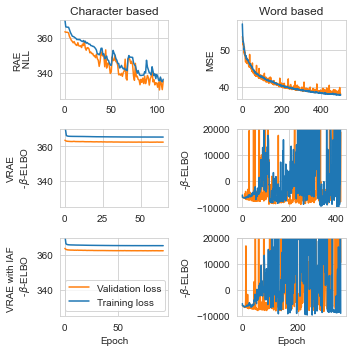

In [93]:
fig, axes =  plt.subplots( nrows=3, ncols=2, figsize=(5,5))

axes[0][0].plot(t_info_rae_c["validation_loss"], color="C1")
axes[0][0].plot(t_info_rae_c["training_loss"], color="C0")
axes[1][0].plot(t_info_vrae_c["validation_loss"], color="C1")
axes[1][0].plot(t_info_vrae_c["training_loss"], color="C0")
axes[2][0].plot(t_info_vrae_iaf_c["validation_loss"],label='Validation loss', color="C1")
axes[2][0].plot(t_info_vrae_iaf_c["training_loss"],label='Training loss', color="C0")
axes[0][1].plot(t_info_rae_w["validation_loss"], color="C1")
axes[0][1].plot(t_info_rae_w["training_loss"], color="C0")
axes[1][1].plot(t_info_vrae_w["validation_loss"], color="C1")
axes[1][1].plot(t_info_vrae_w["training_loss"], color="C0")
axes[2][1].plot(t_info_vrae_iaf_w["validation_loss"], color="C1")
axes[2][1].plot(t_info_vrae_iaf_w["training_loss"], color="C0")

axes[2][0].legend()

axes[0][0].set_ylim(325, 370)
axes[1][0].set_ylim(325, 370)
axes[2][0].set_ylim(325, 370)

axes[1][1].set_ylim(-10000, 20000)
axes[2][1].set_ylim(-10000, 20000)

axes[0][0].set_title("Character based")
axes[0][1].set_title("Word based")

axes[0][0].set_ylabel("RAE\n NLL")
axes[1][0].set_ylabel("VRAE\n -$\\beta$-ELBO")
axes[2][0].set_ylabel("VRAE with IAF \n -$\\beta$-ELBO")

axes[0][1].set_ylabel("MSE")
axes[1][1].set_ylabel("-$\\beta$-ELBO")
axes[2][1].set_ylabel("-$\\beta$-ELBO")

axes[2][0].set_xlabel("Epoch")
axes[2][1].set_xlabel("Epoch")

fig.tight_layout()
fig.savefig(figure_directory / "init_training.pdf")

As we can see, this is challenged

## Out of distribution detection

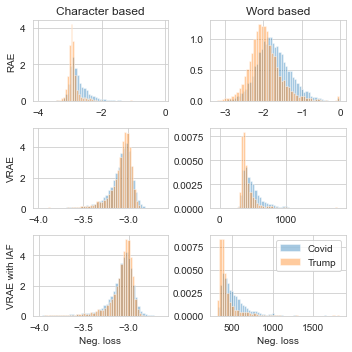

In [94]:
results =  torch.load(Path(".") / "reports" / "init_ood_results.pkl")

ll_in_distribution = results["ll_in_distribution"]
ll_out_of_distribution = results["ll_out_of_distribution"]
diagnostics_in_distribution = results["diagnostics_in_distribution"]
diagnostics_out_of_distribution = results["diagnostics_out_of_distribution"]

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(5, 5))

axes[0][0].set_title("Character based")
axes[0][1].set_title("Word based")

axes[0][0].set_ylabel("RAE")
axes[1][0].set_ylabel("VRAE")
axes[2][0].set_ylabel("VRAE with IAF")

axes[2][0].set_xlabel("Neg. loss")
axes[2][1].set_xlabel("Neg. loss")

for i, model_type in enumerate(["rae", "vrae", "vrae_iaf"]):
    for j, domain in enumerate(["character", "word"]):
        
        ood_dist = ll_out_of_distribution[f"{domain}_{model_type}"]
        id_dist = ll_in_distribution[f"{domain}_{model_type}"]

        # Only considering obervations within a reasonable interval
        min_ood, max_ood = np.quantile(ood_dist,(0.005, 0.999)) 
        min_id, max_id = np.quantile(id_dist,(0.005, 0.999)) 

        if domain == "character":
            min_id = -4
            min_ood = -4
            max_id = 0
            max_ood = 0 

        ood_filtered = [x for x in ood_dist if x < max_ood and x > min_ood]
        id_filtered = [x for x in id_dist if x < max_id and x > min_id]

        sns.distplot(id_filtered, label="Covid", ax=axes[i][j], kde=False,
            norm_hist=True)
        sns.distplot(ood_filtered, label="Trump", ax=axes[i][j], kde=False,
            norm_hist=True)

plt.legend()
fig.tight_layout()

fig.savefig(figure_directory / "init_ood.pdf")

In [98]:
columns = pd.MultiIndex.from_product([["ELBO/loglik/neg. SSE", "KL-div"], ["Covid", "Trump"]]) 
rows = pd.Index(["Word RAE", "Word VRAE", "Word IAF", "Char. RAE", "Char. VRAE", "Char. IAF"])

summary = pd.DataFrame(index=rows, columns=columns)

summary.loc[:, [['KL-div', 'Covid']]] = [
    np.NaN,
    np.mean(diagnostics_in_distribution['word_vrae']['kl']),
    np.mean(diagnostics_in_distribution['word_vrae_iaf']['kl']),
    np.NaN,
    np.mean(diagnostics_in_distribution['character_vrae']['kl']),
    np.mean(diagnostics_in_distribution['character_vrae_iaf']['kl']),
]

summary.loc[:, [['KL-div', 'Trump']]] = [
    np.NaN,
    np.mean(diagnostics_out_of_distribution['word_vrae']['kl']),
    np.mean(diagnostics_out_of_distribution['word_vrae_iaf']['kl']),
    np.NaN,
    np.mean(diagnostics_out_of_distribution['character_vrae']['kl']),
    np.mean(diagnostics_out_of_distribution['character_vrae_iaf']['kl']),
]

summary.loc[:, [["ELBO/loglik/neg. SSE", 'Covid']]] = [
    np.mean(ll_in_distribution['word_rae']),
    np.mean(ll_in_distribution['word_vrae']),
    np.mean(ll_in_distribution['word_vrae_iaf']),
    np.mean(ll_in_distribution['character_rae']),
    np.mean(ll_in_distribution['character_vrae']),
    np.mean(ll_in_distribution['character_vrae_iaf']),
]

summary.loc[:, [["ELBO/loglik/neg. SSE", 'Trump']]] = [
    np.mean(ll_out_of_distribution['word_rae']),
    np.mean(ll_out_of_distribution['word_vrae']),
    np.mean(ll_out_of_distribution['word_vrae_iaf']),
    np.mean(ll_out_of_distribution['character_rae']),
    np.mean(ll_out_of_distribution['character_vrae']),
    np.mean(ll_out_of_distribution['character_vrae_iaf']),
]

display(summary)

summary.to_latex(
    buf=table_directory / "init_summary.tex",
    caption="""
    Average fitness statistics for each model on the two test datasets. 
    The statistics are normalized with the sequence lengths. 
    Average value of KL term across each dataset for each model is also included.
    \\vspace{4}
    """, 
    label="tab:init-results", 
    na_rep="-", 
    float_format="%.3f" 
    )

ELBO/loglik/neg. SSE                  KL-div            
                          Covid       Trump       Covid       Trump
Word RAE              -1.748168   -1.970639         NaN         NaN
Word VRAE             29.111699 -671.436844  280.997290  287.847818
Word IAF             423.776171 -407.752877  252.673446  247.332679
Char. RAE             -2.723400   -2.983748         NaN         NaN
Char. VRAE            -3.099382   -3.621263   -0.000011   -0.000087
Char. IAF             -3.098063   -3.689929    0.000022    0.001340

# Character models with beta scheduling

## Loading training information
The code below loads the initially trained models along with training information

In [99]:
character_rae, t_info_rae_c = get_trained_model(
    character_rae, training_info=True, model_name="CharacterRAE", subdir='beta-scheduling', latest=True,
    )
character_vrae, t_info_vrae_c = get_trained_model(
    character_vrae, training_info=True, model_name="CharacterVRAE", subdir='beta-scheduling', latest=True,
    )
character_vrae_iaf, t_info_vrae_iaf_c = get_trained_model(
    character_vrae_iaf, training_info=True, model_name="CharacterVRAEIAF", subdir='beta-scheduling', latest=True
    )

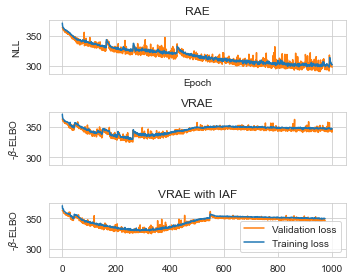

In [100]:
fig, axes =  plt.subplots( nrows=3, ncols=1, figsize=(5,4), sharex=True, sharey=True)

axes[0].plot(t_info_rae_c["validation_loss"], color="C1")
axes[0].plot(t_info_rae_c["training_loss"], color="C0")
axes[1].plot(t_info_vrae_c["validation_loss"], color="C1")
axes[1].plot(t_info_vrae_c["training_loss"], color="C0")
axes[2].plot(t_info_vrae_iaf_c["validation_loss"],label='Validation loss', color="C1")
axes[2].plot(t_info_vrae_iaf_c["training_loss"],label='Training loss', color="C0")

axes[2].legend()


axes[0].set_title("RAE")
axes[1].set_title("VRAE")
axes[2].set_title("VRAE with IAF")

axes[0].set_ylabel("NLL")
axes[1].set_ylabel("-$\\beta$-ELBO")
axes[2].set_ylabel("-$\\beta$-ELBO")

axes[0].set_xlabel("Epoch")

fig.tight_layout()
fig.savefig(figure_directory / "new_training.pdf")

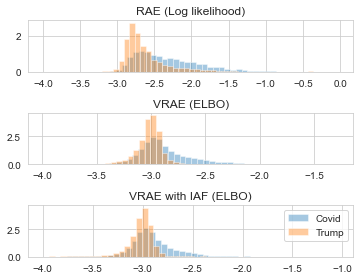

In [101]:
results =  torch.load(Path(".") / "reports" / "new_ood_results.pkl")

ll_in_distribution = results["ll_in_distribution"]
ll_out_of_distribution = results["ll_out_of_distribution"]
diagnostics_in_distribution = results["diagnostics_in_distribution"]
diagnostics_out_of_distribution = results["diagnostics_out_of_distribution"]

fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(5, 4))

axes[0].set_title("RAE (Log likelihood)")
axes[1].set_title("VRAE (ELBO)")
axes[2].set_title("VRAE with IAF (ELBO)")

min_ = -4
max_ = 0

for i, model_type in enumerate(["rae", "vrae", "vrae_iaf"]):
    
    ood_dist = ll_out_of_distribution[f"character_{model_type}"]
    id_dist = ll_in_distribution[f"character_{model_type}"]

    # Only considering obervations within a reasonable interval for plotting
    ood_filtered = [x for x in ood_dist if x < max_ and x > min_]
    id_filtered = [x for x in id_dist if x < max_ and x > min_]

    sns.distplot(id_filtered, label="Covid", ax=axes[i], kde=False,
        norm_hist=True)
    sns.distplot(ood_filtered, label="Trump", ax=axes[i], kde=False,
        norm_hist=True)

plt.legend()
fig.tight_layout()

fig.savefig(figure_directory / "new_ood.pdf")

In [102]:
columns = pd.MultiIndex.from_product([["ELBO/loglik/neg. SSE", "KL-div"], ["Covid", "Trump"]]) 
rows = pd.Index(["Char. RAE", "Char. VRAE", "Char. IAF"])

summary = pd.DataFrame(index=rows, columns=columns)

summary.loc[:, [['KL-div', 'Covid']]] = [
    np.nan,
    np.mean(diagnostics_in_distribution['character_vrae']['kl']),
    np.mean(diagnostics_in_distribution['character_vrae_iaf']['kl']),
]

summary.loc[:, [['KL-div', 'Trump']]] = [
    np.NaN,
    np.mean(diagnostics_out_of_distribution['character_vrae']['kl']),
    np.mean(diagnostics_out_of_distribution['character_vrae_iaf']['kl']),
]

summary.loc[:, [["ELBO/loglik/neg. SSE", 'Covid']]] = [
    np.mean(ll_in_distribution['character_rae']),
    np.mean(ll_in_distribution['character_vrae']),
    np.mean(ll_in_distribution['character_vrae_iaf']),
]

summary.loc[:, [["ELBO/loglik/neg. SSE", 'Trump']]] = [
    np.mean(ll_out_of_distribution['character_rae']),
    np.mean(ll_out_of_distribution['character_vrae']),
    np.mean(ll_out_of_distribution['character_vrae_iaf']),
]

display(summary)

summary.to_latex(
    buf=table_directory / "new_summary.tex",
    caption="""
    Average fitness statistics for the models trained with variable $\\beta$ parameter on character datasets. 
    The statistics are normalized with the sequence lengths. 
    Average value of KL term across the dataset for each model is also included.
    \\vspace{4}
    """, 
    label="tab:new-results", 
    na_rep="-", 
    float_format="%.3f" 
    )

ELBO/loglik/neg. SSE               KL-div           
                          Covid     Trump      Covid      Trump
Char. RAE             -2.312821 -2.819691        NaN        NaN
Char. VRAE            -2.893007 -3.805173  15.427555  12.629908
Char. IAF             -2.909022 -4.821195  14.898845  14.443335